<a href="https://colab.research.google.com/github/jchen0000/widsdatathon2025/blob/main/python/Jiaqi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import squareform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [22]:
# prompt: Access data from google drive
from google.colab import drive
drive.mount('/content/drive')

# Import train categorical data (1213, 10)
train_cat = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx")
# train_cat.shape
# train_cat.describe()

# Import train quantitative data (1213, 19)
train_quant = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx")
# train_quant.shape
# train_quant.describe()

# Import train
#train_func = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_METADATA.xlsx")
# train_func.shape
# train_func.describe()


# Import solution w outcome data (1213, 3)
train_sol = pd.read_excel("drive/My Drive/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx")
# train_sol.shape
# train_sol.describe()

# Import MRI data (1213, 19901)
mri_filepath = "drive/My Drive/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
mri = pd.read_csv(mri_filepath)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The matrix and heatmap in your MRI dataset represent functional connectivity between different regions of the brain for each subject.
The 200x200 matrix represents pairwise connectivity between different brain regions, where 200 is the number of regions.

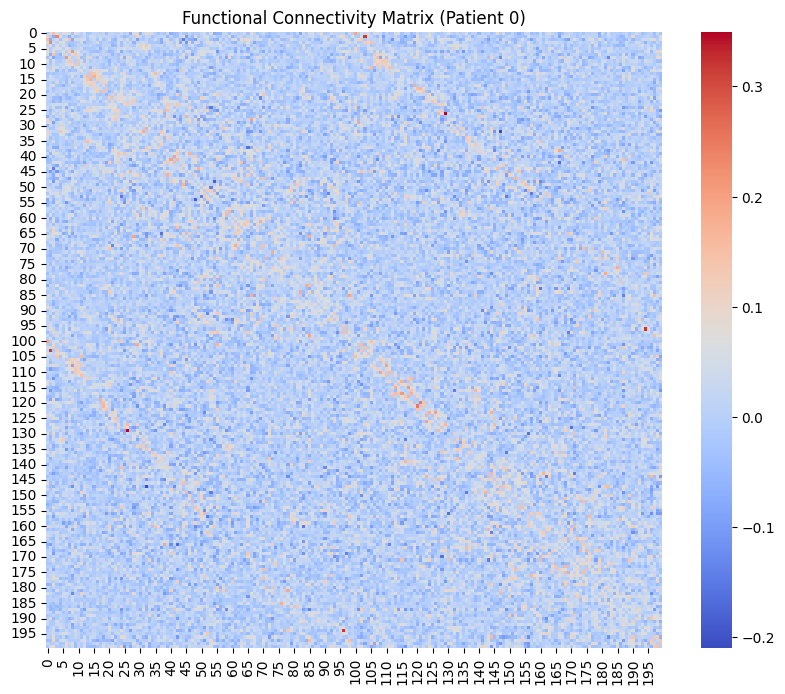

In [30]:
# Process MRI data

# Columns represent a functional connectivity matrix.
# N = 200 meaning each patient’s connectivity matrix is 200 × 200
N = int((1 + np.sqrt(1 + 8 * 19900)) / 2)

# Remove first line, convert csv file to a functional connectome matrix
matrix_data = mri.iloc[:, 1:].to_numpy(dtype=float)

# Convert first patient’s vector (19900 values) to full 200x200 matrix
subject_index = 0    # patient n (0, 1212)
subject_vector = matrix_data[subject_index]
subject_matrix = squareform(subject_vector)  # Reconstruct NxN matrix

# MRI Heatmap of one patient
plt.figure(figsize=(10, 8))
sns.heatmap(subject_matrix, cmap="coolwarm", square=True)
plt.title(f"Functional Connectivity Matrix (Patient {subject_index})")
plt.show()



In [ ]:
# Merge datasets on the participant ID  (1213, 30)
combined_data = pd.merge(train_cat, train_quant, on='participant_id')
combined_data = pd.merge(combined_data, train_sol, on='participant_id')

# Separate input and outcome variable
X = combined_data.drop(columns=['participant_id', 'ADHD_Outcome'])  # (1213, 28)
y = combined_data['ADHD_Outcome']    # (1213, 1)

In [ ]:
# Preprocessing: Scale all numeric features
scaler = StandardScaler()

# Build pipeline
pipeline = Pipeline(steps=[
    ('scaler', scaler),  # Scale all numeric features
    ('classifier', RandomForestClassifier())
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

# Make predictions
predictions = pipeline.predict(X_test)

# Prepare final output with ID, Outcome, Gender, and Predictions
X_test_final = combined_data.loc[X_test.index, ['participant_id', 'ADHD_Outcome', 'Sex_F']]
X_test_final['Prediction'] = predictions

# Display final output
print(X_test_final)


    participant_id  ADHD_Outcome  Sex_F  Prediction
382   M6malGe8P7Ic             1      1           1
787   XBAesR0BxzjQ             1      0           1
43    PtxdLLjvEhIS             1      0           1
155   OGitd7RL4GlH             1      0           1
493   X6mFs3EnxuJt             1      1           0
..             ...           ...    ...         ...
59    m4lTzGns4f6M             1      0           1
837   vrhTp07N2M92             0      0           1
63    wHhpfK5aJYE6             1      0           1
722   o6MXPHR32N94             1      0           1
644   LzoOSXImj5i4             1      0           1

[243 rows x 4 columns]
